<a href="https://colab.research.google.com/github/shanky474/pfizer_case_study_customer_churn/blob/main/ML_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data_encoded = pd.read_csv(r'drive/MyDrive/Pfizer_Assessment/Feature_Store/Telco-Customer-Churn-Features.csv')

In [ ]:
data_encoded.head()

,SeniorCitizen,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank_transfer_(automatic),PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,0,0,1,0,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
1,0,0,0,1,1,0,1,0,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,1,0,1,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,0,0,1,1,0,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,0,1,1,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0


In [ ]:
data_encoded['Churn'].value_counts()

,count
Churn,
0,5163
1,1869


Class imbalance noted for target variable hence using upsampling to correct it.

In [ ]:
from sklearn.utils import resample

# Separate majority and minority classes
data_encoded_majority = data_encoded[data_encoded.Churn==0]
data_encoded_minority = data_encoded[data_encoded.Churn==1]

# Upsample minority class
data_encoded_minority_upsampled = resample(data_encoded_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=	5163,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data_encoded_upsampled = pd.concat([data_encoded_majority, data_encoded_minority_upsampled])

# Display new class counts
data_encoded_upsampled.Churn.value_counts()

,count
Churn,
0,5163
1,5163


Split data into train, validation, testing

In [ ]:
X = data_encoded_upsampled.drop(['Churn'], axis=1)
Y = data_encoded_upsampled['Churn']


# Shuffles and splits into 60%, 20%, 20%
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101, stratify=Y)
# train, val, test = np.split(data_encoded.sample(frac=1, random_state=42),
#                            [int(.6*len(data_encoded)), int(.8*len(data_encoded))])

Trying Logistic Regression for classification

In [ ]:
model = LogisticRegression()

In [ ]:
# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga'] # SAGA supports l1 and l2
}
# Apply Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy')

Predict output as well as probablities using the best Logistic Regression estimator derived from GridSearch

In [ ]:
y_test_pred_log_res = grid_search.best_estimator_.predict(X_test)

In [ ]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_log_res = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

Evaluating performance metrics Accuracy, Precision, Recall, F1-score

In [ ]:
print(confusion_matrix(y_test, y_test_pred_log_res))

[[1136  413]
 [ 311 1238]]


In [ ]:
accuracy_score(y_test, y_test_pred_log_res)

0.7663008392511298

In [ ]:
precision_score(y_test, y_test_pred_log_res)

0.7498485766202302

In [ ]:
recall_score(y_test, y_test_pred_log_res)

0.7992253066494512

In [ ]:
f1_score(y_test, y_test_pred_log_res)

0.77375

We see the following observations for Logistic regression model for 5000 iterations with grid search:
1. The best estimator is LogisticRegression(C=np.float64(0.03359818286283781), solver='liblinear')

Now we try Decision tree classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the classifier
clf_model = DecisionTreeClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 100),
    'criterion': ['gini', 'entropy']
}

# Define parameter grid
grid_search = GridSearchCV(
    estimator=clf_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy', # Use a relevant scoring metric
    n_jobs=-1 # Use all available processors
)


grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_split': range(2, 100)},
             scoring='accuracy')

In [ ]:
# Make predictions
y_test_pred_dec_tree = grid_search.best_estimator_.predict(X_test)

In [ ]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_dec_tree = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
confusion_matrix(y_test, y_test_pred_dec_tree)

array([[1158,  391],
       [ 292, 1257]])

In [ ]:
accuracy_score(y_test, y_test_pred_dec_tree)

0.7795351839896708

In [ ]:
precision_score(y_test, y_test_pred_dec_tree)

0.7627427184466019

In [ ]:
recall_score(y_test, y_test_pred_dec_tree)

0.8114912846998064

In [ ]:
f1_score(y_test, y_test_pred_dec_tree)

0.7863622145761652

Now we try Random forest classifier

In [ ]:
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "log2",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', max_leaf_nodes=30,
                       n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=50)

In [ ]:
%%script false --no-raise-error

param_grid = {
    'n_estimators': [100, 200, 500,1000,1500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}

# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Set up GridSearchCV
# cv=5 means 5-fold cross-validation
# n_jobs=-1 means use all available processors for faster computation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

In [ ]:
y_test_pred_rf=model_rf.predict(X_test)

In [ ]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_rf = model_rf.predict_proba(X_test)[:, 1]

In [ ]:
confusion_matrix(y_test, y_test_pred_rf)

array([[1135,  414],
       [ 303, 1246]])

In [ ]:
accuracy_score(y_test, y_test_pred_rf)

0.7685603615235636

In [ ]:
precision_score(y_test, y_test_pred_rf)

0.7506024096385542

In [ ]:
recall_score(y_test, y_test_pred_rf)

0.8043899289864429

In [ ]:
f1_score(y_test, y_test_pred_rf)

0.7765659083826737

Now we would try SVM

In [ ]:
from sklearn.svm import SVC

model.svm = SVC(kernel='linear',probability=True)
model.svm.fit(X_train,y_train)
y_test_pred_svm = model.svm.predict(X_test)

In [ ]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_svm = model.svm.predict_proba(X_test)[:, 1]

In [ ]:
confusion_matrix(y_test, y_test_pred_svm)

array([[1044,  505],
       [ 252, 1297]])

In [ ]:
accuracy_score(y_test, y_test_pred_svm)

0.7556488056810846

In [ ]:
precision_score(y_test, y_test_pred_svm)

0.7197558268590455

In [ ]:
recall_score(y_test, y_test_pred_svm)

0.8373143963847643

In [ ]:
f1_score(y_test, y_test_pred_svm)

0.7740972843927186

Now we try XGBoost

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,                # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,           # Use all available cores
    verbose=1
)

grid_search.fit(X_train, y_train)
y_test_pred_xgb = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_xgb = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
confusion_matrix(y_test, y_test_pred_xgb)

array([[1198,  351],
       [ 170, 1379]])

In [ ]:
accuracy_score(y_test, y_test_pred_xgb)

0.8318269851517108

In [ ]:
recall_score(y_test, y_test_pred_xgb)

0.8902517753389283

In [ ]:
f1_score(y_test, y_test_pred_xgb)

0.8411100945410186

Now we try AdaBoost

In [ ]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}

# 4. Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,  # Number of cross-validation splits
    scoring='accuracy', # Metric to optimize
    n_jobs=-1, # Use all available cores for parallel processing
    verbose=1
)
grid_search.fit(X_train,y_train)
y_test_pred_adaboost = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_adaboost = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
confusion_matrix(y_test, y_test_pred_adaboost)

array([[1134,  415],
       [ 301, 1248]])

In [ ]:
accuracy_score(y_test, y_test_pred_adaboost)

0.7688831504196255

In [ ]:
precision_score(y_test, y_test_pred_adaboost)

0.7504509921828022

In [ ]:
recall_score(y_test, y_test_pred_adaboost)

0.8056810845706908

In [ ]:
f1_score(y_test, y_test_pred_adaboost)

0.7770859277708593

Now we try LGBoost

In [ ]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50, 100, 200],
    'num_leaves': [10, 31, 50],
    'max_depth': [3, 5, -1], # -1 means no limit
    'boosting_type': ['gbdt', 'dart']
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5, # Number of cross-validation folds
    scoring='accuracy', # Metric for evaluation (e.g., 'accuracy', 'roc_auc', 'neg_mean_squared_error')
    verbose=1, # Controls the verbosity of the output
    n_jobs=-1 # Use all available cores for parallel processing
)
grid_search.fit(X_train, y_train)
y_test_pred_lgbm = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[LightGBM] [Info] Number of positive: 3614, number of negative: 3614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 7228, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# 3. Predict probabilities for the positive class (1)
y_test_prob_lgbm = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

In [ ]:
confusion_matrix(y_test, y_test_pred_lgbm)

array([[1189,  360],
       [ 169, 1380]])

In [ ]:
accuracy_score(y_test, y_test_pred_lgbm)

0.829244673983215

In [ ]:
precision_score(y_test, y_test_pred_lgbm)

0.7931034482758621

In [ ]:
recall_score(y_test, y_test_pred_lgbm)

0.8908973531310523

In [ ]:
f1_score(y_test, y_test_pred_lgbm)

0.8391608391608392

Plot the ROC/AUC curves

In [ ]:
prob_dict = {'Logreg':y_test_prob_log_res,
             'DecisionTreeClassifier':y_test_prob_dec_tree,
             'RandomForestClassifier':y_test_prob_rf,
             'SVM':y_test_prob_svm,
             'XGB':y_test_prob_xgb,
             'Adaboost':y_test_prob_adaboost,
             'LGBM':y_test_prob_lgbm}

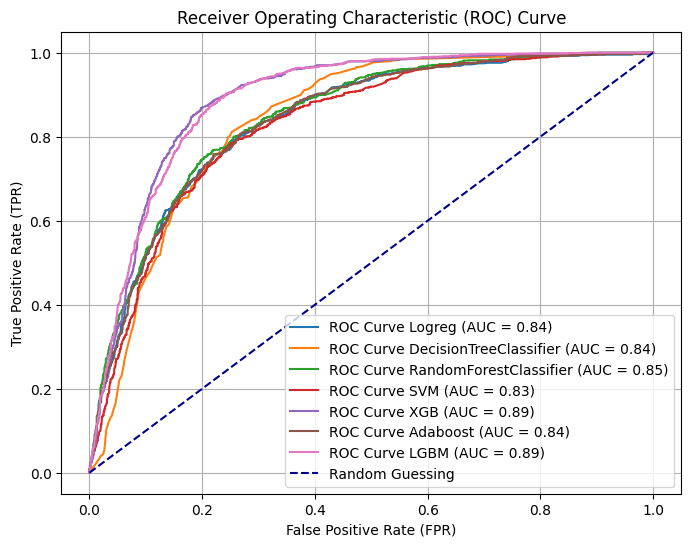

In [ ]:


# 5. Plot the ROC curve
plt.figure(figsize=(8, 6))
for k,v in prob_dict.items():
  auc = roc_auc_score(y_test, v)
  fpr, tpr, thresholds = roc_curve(y_test, v)
  plt.plot(fpr, tpr, label=f'ROC Curve {k} (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()